In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import time
import random

import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

### Data Exploration

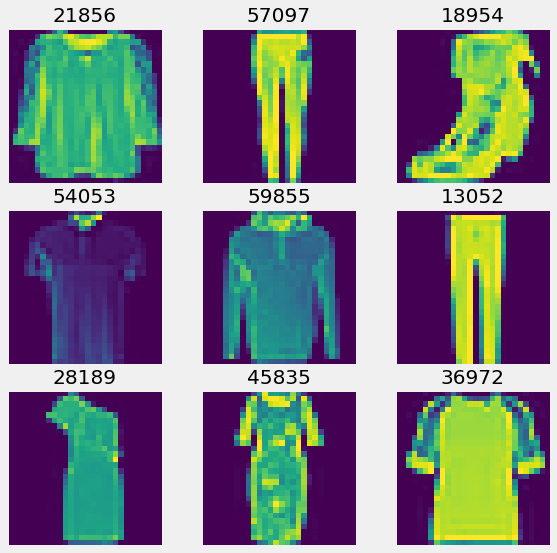

In [80]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#plot sample of random images
figure, axes = plt.subplots(3,3,figsize=(8,8))
axes = axes.reshape(9)
for i,index in enumerate(np.random.randint(0,59999,9)):
    axes[i].imshow(x_train[index])
    axes[i].set_title(str(index))
    plt.tight_layout()
    axes[i].set_xticks([])
    axes[i].set_yticks([])

### Data Processing and CNN

In [17]:
#scaling to ease computational burden of model
#note: scaling does not change the way the image renders
x_train_scaled = x_train/255
x_test_scaled = x_test/255

#convert to float 32 to use less space, float64 uses twice as much memory
x_train_scaled_32 = x_train_scaled.astype('float32')
x_test_scaled_32 = x_test_scaled.astype('float32')

#reshape to 4d array with expected input shape of (batch, rows, columns, channels)
x_train_scaled_shape = x_train_scaled_32.reshape(x_train_scaled_32.shape[0], 28, 28, 1)
x_test_scaled_shape = x_test_scaled_32.reshape(x_test_scaled_32.shape[0], 28, 28, 1)

#convert labels to one-hot-encoded arrays
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

categories = {0: 'T-shirt/top',
             1: 'Trouser',
             2: 'Pullover',
             3: 'Dress',
             4: 'Coat',
             5: 'Sandal',
             6: 'Shirt',
             7: 'Sneaker',
             8: 'Bag',
             9: 'Boot'}

In [18]:
#model 1: 1 convolutional layer, one dense layer
#what happens when you remove flatten?
#test effect of kernel size
#test effect of number of filters
#test effect of number of layers
#test effect of maxpooling
kernels = [(3,3), (5,5), (10,10), (28,28)]
results_kernel = pd.DataFrame()
for kernel in kernels:
    model_kernel = Sequential([Conv2D(filters=10, kernel_size=kernel, activation='relu', input_shape=x_train_scaled_shape.shape[1:]),
                        Flatten(),
                       Dense(10, activation='softmax')])
    
    model_kernel.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    #calculate time per model
    start_time = time.time()
    epochs=5
    results = model_kernel.fit(x_train_scaled_shape, y_train_cat, batch_size=100, epochs=epochs, verbose=0, validation_split=0.2)
    end_time = time.time()
    model_time = end_time-start_time
    
    #append model history to results_kernel dataframe
    history = pd.DataFrame(results.history)
    history['kernel_dim'] = kernel[0]
    history['model_time'] = model_time
    history['epoch'] = list(range(1,epochs+1))
    results_kernel = results_kernel.append(history)
    

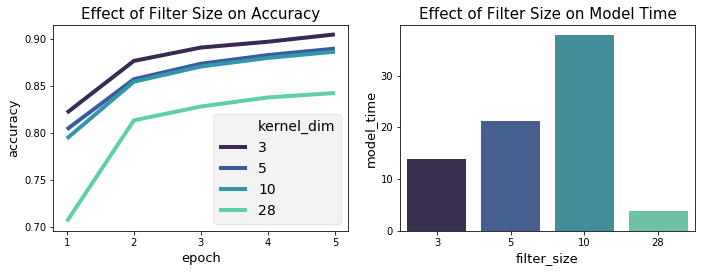

In [19]:
#visualize kernel size effect
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes = axes.flatten()

palette_size = len(results_kernel['kernel_dim'].unique())
plt.style.use('fivethirtyeight')
sns.lineplot(results_kernel['epoch'], results_kernel['accuracy'], hue=results_kernel['kernel_dim'],
            palette=sns.color_palette("mako", palette_size),ax = axes[0])
axes[0].set_title('Effect of Filter Size on Accuracy',size=15)
axes[0].set_xlabel('epoch',size=13)
axes[0].set_ylabel('accuracy', size=13)
axes[0].grid(False)

sns.barplot(results_kernel['kernel_dim'], results_kernel['model_time'], palette='mako', ax=axes[1])
axes[1].set_title('Effect of Filter Size on Model Time',size=15)
axes[1].set_xlabel('filter_size',size=13)
axes[1].set_ylabel('model_time', size=13)
axes[1].grid(False)
plt.tight_layout()

In [20]:
#effect of number of filters on results
filters = [5,10,30,50]
results_kernel = pd.DataFrame()
for filter_num in filters:
    model_kernel = Sequential([Conv2D(filters=filter_num, kernel_size=(3,3), activation='relu', input_shape=x_train_scaled_shape.shape[1:]),
                        Flatten(),
                       Dense(10, activation='softmax')])
    
    model_kernel.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    #calculate time per model
    start_time = time.time()
    epochs=5
    results = model_kernel.fit(x_train_scaled_shape, y_train_cat, batch_size=100, epochs=epochs, verbose=0, validation_split=0.2)
    end_time = time.time()
    model_time = end_time-start_time
    
    #append model history to results_kernel dataframe
    history = pd.DataFrame(results.history)
    history['filters'] = filter_num
    history['model_time'] = model_time
    history['epoch'] = list(range(1,epochs+1))
    results_kernel = results_kernel.append(history)
    

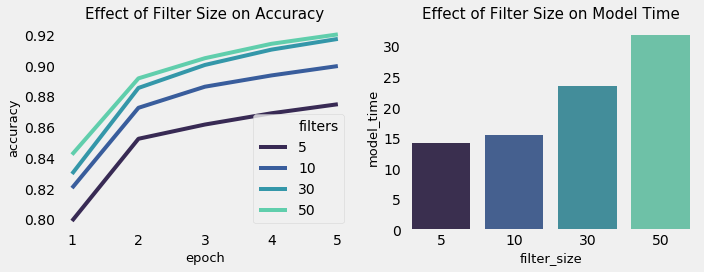

In [21]:
#visualize number of filters
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes = axes.flatten()

palette_size = len(results_kernel['filters'].unique())
plt.style.use('fivethirtyeight')
sns.lineplot(results_kernel['epoch'], results_kernel['accuracy'], hue=results_kernel['filters'],
            palette=sns.color_palette("mako", palette_size),ax = axes[0])
axes[0].set_title('Effect of Filter Size on Accuracy',size=15)
axes[0].set_xlabel('epoch',size=13)
axes[0].set_ylabel('accuracy', size=13)
axes[0].grid(False)

sns.barplot(results_kernel['filters'], results_kernel['model_time'], palette='mako', ax=axes[1])
axes[1].set_title('Effect of Filter Size on Model Time',size=15)
axes[1].set_xlabel('filter_size',size=13)
axes[1].set_ylabel('model_time', size=13)
axes[1].grid(False)
plt.tight_layout()

In [22]:
# datagen = ImageDataGenerator(rotation_range=10,
#                             zoom_range=0.1,
#                             width_shift_range=0.1,
#                             height_shift_range=0.1)

# epochs = 3
# batch_size = 100
# history = model.fit_generator(datagen.flow(x_train_sample, y_train_sample, batch_size=batch_size), epochs=epochs,
#                              validation_data=(x_test_sample, y_test_sample), steps_per_epoch=x_train_sample.shape[0//batch_size])


### Prediction analysis

In [24]:
#calculate predictions
predictions = model_kernel.predict(x_test_sample)

counts=Counter()
for x,y in zip(predictions, y_test):
    if np.argmax(x)==y:
        counts[y] +=1
        
counts

Counter({9: 956,
         2: 740,
         1: 977,
         6: 687,
         4: 916,
         5: 959,
         7: 962,
         3: 863,
         8: 970,
         0: 865})

In [37]:
#compare predicted to actuals
pred_labels = [np.argmax(x) for x in predictions]
pred_actual = pd.DataFrame(zip(y_test, pred_labels)).rename(columns={0:'actual', 1:'predicted'})
pred_actual['actual_label'] = pred_actual['actual'].map(categories)
pred_actual['predicted_label'] = pred_actual['predicted'].map(categories)
pred_actual['correct'] = pred_actual['actual'] == pred_actual['predicted']
pred_actual

pred_actual.groupby('actual_label')['correct'].aggregate({'sum':sum, 'total':len})

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  if __name__ == '__main__':


,sum,total
actual_label,,
Bag,970.0,1000
Boot,956.0,1000
Coat,916.0,1000
Dress,863.0,1000
Pullover,740.0,1000
Sandal,959.0,1000
Shirt,687.0,1000
Sneaker,962.0,1000
T-shirt/top,865.0,1000


In [94]:
test = incorrect.groupby(['actual_label','predicted_label'])['actual'].count().sort_values(ascending=False).to_frame()
test = test.reset_index()
test['labels'] = test['actual_label'] + '_'+ test['predicted_label']
test.head()

,actual_label,predicted_label,actual,labels
0,Pullover,Coat,147,Pullover_Coat
1,Shirt,T-shirt/top,134,Shirt_T-shirt/top
2,Shirt,Coat,106,Shirt_Coat
3,T-shirt/top,Shirt,96,T-shirt/top_Shirt
4,Pullover,Shirt,78,Pullover_Shirt


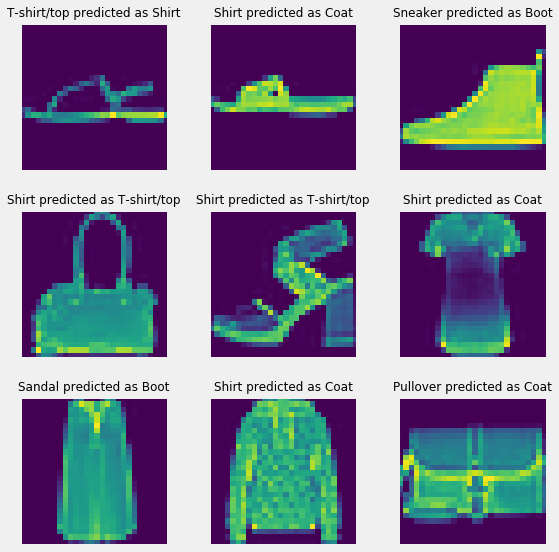

In [85]:
#closer look at shirts, most incorrectly predicted label
#something is very wrong with these labels lol
incorrect = pred_actual[pred_actual['actual_label']!=pred_actual['predicted_label']]
incorrect_indices = incorrect.index

sampling_incorrect = random.choices(incorrect_indices, k=9)
fig, axes = plt.subplots(3,3,figsize=(8,8))
axes = axes.flatten()

for i,index in enumerate(sampling_incorrect):
    actual_label = pred_actual.iloc[index]['actual_label']
    predicted_label = pred_actual.iloc[index]['predicted_label']
    axes[i].imshow(x_train_scaled[index])
    axes[i].set_title(actual_label +' predicted as '+predicted_label, size=12)
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()

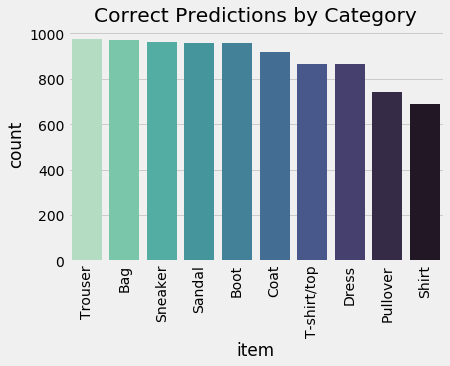

In [29]:
#plot frequency of accurate predictions by category
predicted = pd.DataFrame.from_dict(counts, orient='index').reset_index().rename(columns={'index':'label', 0:'count'})
predicted['item'] = predicted['label'].map(categories)
predicted = predicted.sort_values('count', ascending=False)
sns.barplot(predicted['item'], predicted['count'], palette='mako_r')
plt.title('Correct Predictions by Category')
ticks=plt.xticks(rotation='vertical')

In [30]:
#save and load a model
model.save('mnist_fashion.model')
new_model = tf.keras.models.load_model('mnist_fashion.model')